# Vizualise similarities in sentence embeddings

Ici, je prends trois triplets de phrases. Dans chacun de ces triplets, j'ai 2 phrases qui sont volontairement similaires (qui veulent dire la même chose) et une parlant du même sujet mais qui n'a pas le même sens. Le but est double: premièrement analyser si les embeddings diffèrent dans un triplet donné on s'attend à ce que la phrase avec un un sens différent diffère des deux autres), ensuite vérifier que les phrases qui n'appartiennet pas au même triplet sont vraiment dissimilaires par leurs embeddings.

## 1. Implementation

In [51]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sn

from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent, width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize, ha="center", va="center", fontweight="bold")
        return [tx]
Legend.update_default_handler_map({str : TextHandlerB()})




def encode_sentences(model_name_or_path, sentences):
    """
    Given a list of sentences an d a model, get the embeddings of theses sentences
    as the average of the word embeddings of the last layer.
    """    
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='/raid/antoloui/Master-thesis/_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    lengths = [len(i) for i in tokenized]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(tokenized, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # For each sentence, take the embeddings of its word from the last layer and represent that sentence by their average.
    last_hidden_states = output[0]
    sentence_embeddings = [torch.mean(embeddings[:torch.squeeze((masks == 1).nonzero(), dim=1).shape[0]], dim=0).numpy() for embeddings, masks in zip(last_hidden_states, attention_mask)]
    sentence_embeddings = np.array(sentence_embeddings)

    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_embeddings.shape[1])]
    df = pd.DataFrame(data=sentence_embeddings[:,:], columns=cols)
    df['Sentence'] = sentences
    return df


def compute_compactness(embeddings):
    scores = []
    for w in embeddings:
        idx = np.where(np.all(embeddings==w, axis=1))
        arr = np.delete(embeddings, (idx), axis=0)
        score = 0
        for i, vec_i in enumerate(arr):
            for j, vec_j in enumerate(arr):
                if i != j:
                    score += np.dot(arr[i], arr[j])/(np.linalg.norm(arr[i])*np.linalg.norm(arr[j]))
        scores.append(round(score, 3))
    return np.array(scores)


def plot_scores(scores, sentences):
    """
    """
    df = pd.DataFrame({"Scores": scores}, index=sentences)
    
    ax = plt.plot()
    ax = sn.heatmap(df, annot=True, cmap="coolwarm", cbar_kws = dict(use_gridspec=False,location="left"))
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20, rotation=0)
    fig.tight_layout()
    #fig.savefig("./figures/" + fig_name + ".pdf", bbox_inches='tight')
    plt.show()
    return
    


def run(sentences, fig_name):
    """
    """
    #------------------
    # Get embeddings
    #-----------------
    print("BERT-base")
    bert_df = encode_sentences('bert-base-cased', sentences)
    bert_embeddings = bert_df.loc[:, bert_df.columns != 'Sentence'].values
    bert_scores = compute_compactness(bert_embeddings)
    print(bert_scores)
    plot_scores(bert_scores, sentences)
    
    print("NetBERT")
    netbert_df = encode_sentences('/raid/antoloui/Master-thesis/_models/netbert-final/', sentences)
    netbert_embeddings = netbert_df.loc[:, netbert_df.columns != 'Sentence'].values
    netbert_scores = compute_compactness(netbert_embeddings)
    print(netbert_scores)
    plot_scores(netbert_scores, sentences)
    return


## 2. Tests

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 28 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
[4.951 4.979 4.887 5.74 ]


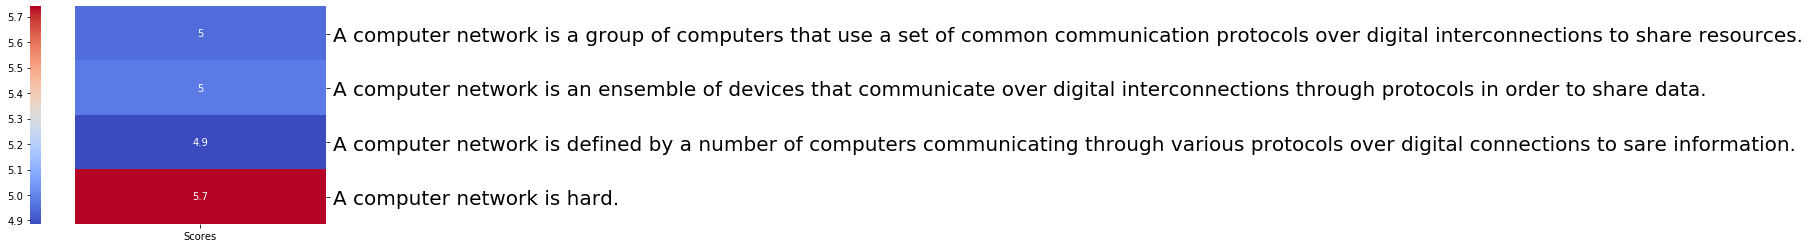

NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 28 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
[5.398 5.422 5.396 5.793]


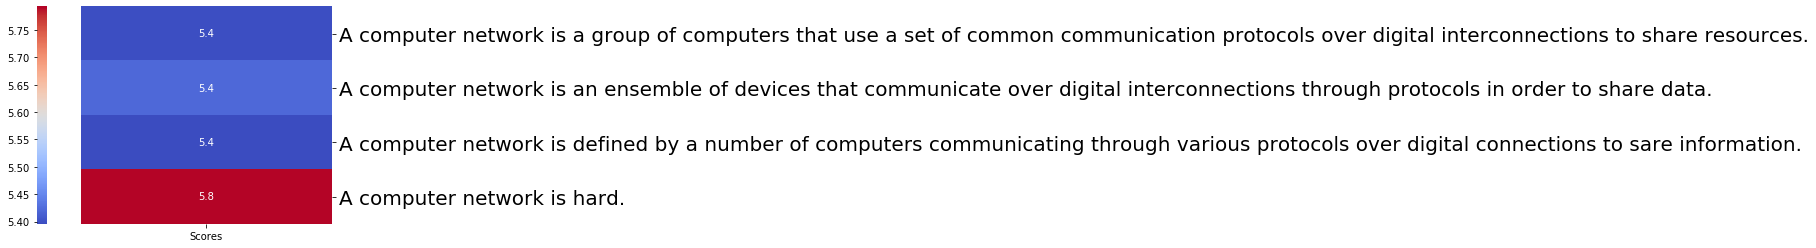

In [65]:
sentences = ['A computer network is a group of computers that use a set of common communication protocols over digital interconnections to share resources.',
             'A computer network is an ensemble of devices that communicate over digital interconnections through protocols in order to share data.',
             'A computer network is defined by a number of computers communicating through various protocols over digital connections to sare information.',
             'A computer network is hard.']
run(sentences, fig_name="outlier_detection_networking")

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 19 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
[1.763 1.773 1.826]


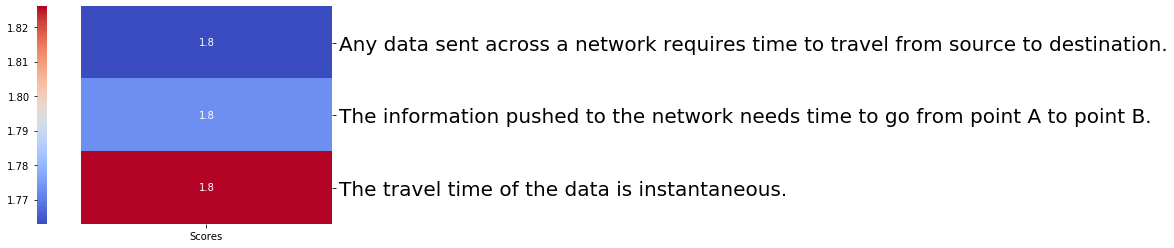

NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 19 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
[1.749 1.788 1.791]


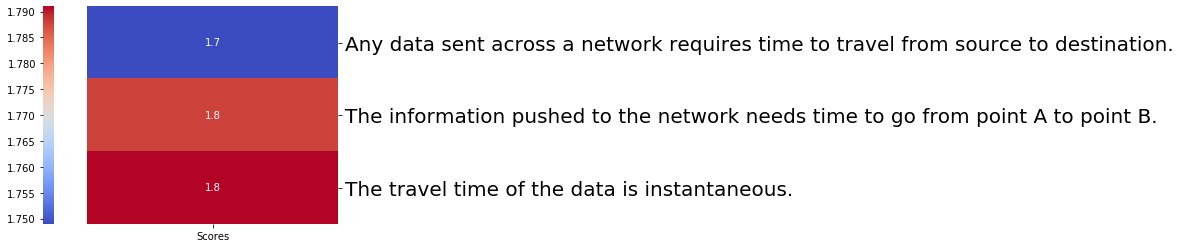

In [53]:
sentences = ['Any data sent across a network requires time to travel from source to destination.',
             'The information pushed to the network needs time to go from point A to point B.',
             'The travel time of the data is instantaneous.']
run(sentences, fig_name="outlier_detection_travel")

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 21 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
[1.775 1.661 1.883]


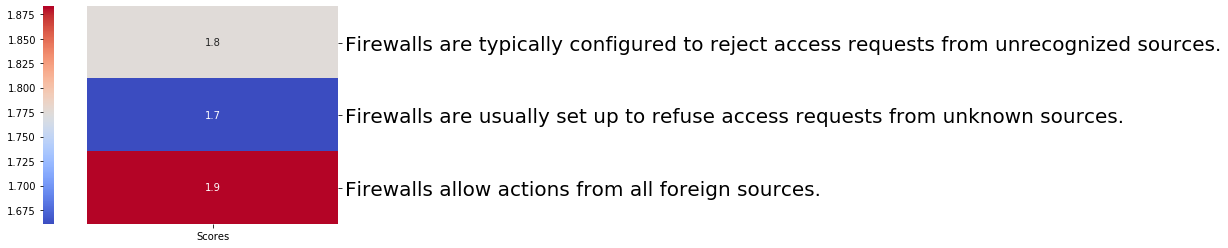

NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 21 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
[1.838 1.809 1.917]


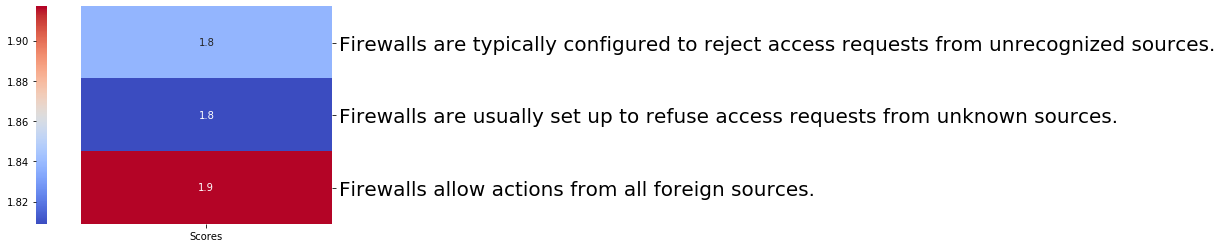

In [54]:
sentences = ['Firewalls are typically configured to reject access requests from unrecognized sources.',
             'Firewalls are usually set up to refuse access requests from unknown sources.',
             'Firewalls allow actions from all foreign sources.']
run(sentences, fig_name="outlier_detection_firewall")